### **IMPORT DEPENDENCIES**

In [17]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.decomposition import PCA, IncrementalPCA, SparsePCA
import sklearn.model_selection as skm
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, LassoCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from scipy.interpolate import interp1d
from sklearn.pipeline import Pipeline

### **DATA PREPROCESSING**

In [18]:
# Load the datasets
train_df= pd.read_excel("Project2_Training.xlsx")
test_df = pd.read_excel("Project2_Test.xlsx")

In [19]:
# Setting all columns to lower to rename them in snake case
train_df.columns = train_df.columns.str.lower()
test_df.columns = test_df.columns.str.lower()

In [20]:
# renaming columns for training and test datasets
train_df.rename(columns={'quotedate' : 'quote_date',
                         'vehicleyear' : 'vehicle_year',
                         'vehiclemake' : 'vehicle_make',
                         'vehiclemodel' : 'vehicle_model',
                         'vehicleuse' : 'vehicle_use'},
                inplace= True)

test_df.rename(columns={'maritalstatus' : 'marital_status',
                        'vehiclemake' : 'vehicle_make',
                        'convictioncountminor3yrs' : 'conviction_count_minor_3yrs',
                        'quotedate' : 'quote_date',
                         'vehicleyear' : 'vehicle_year',
                         'vehiclemodel' : 'vehicle_model',
                         'vehicleuse' : 'vehicle_use',
                        'annualkm' : 'annual_km',
                        'commutedistance': 'commute_distance',
                        'vehiclevalue' : 'vehicle_value',
                        'yearofbirth' : 'year_of_birth',
                        'yearsasprincipaldriver' : 'years_as_principal_driver',
                        'maritalstatus' : 'marital_status',
                        'markingsystem' : 'marking_system',
                        'trackingsystem' : 'tracking_system',
                        'vehicleownership' : 'vehicle_ownership',
                        'postalcode' : 'postal_code',
                        'areacode' : 'area_code',
                        'yearslicensed' : 'years_licensed',
                        'multiproduct' : 'multi_product',
                        'convictioncountmajor3yrs' :'conviction_count_major_3yrs',
                       'convictioncountcriminal3yrs' : 'conviction_count_criminal_3yrs',
                        'assignedlossespd5yrs' : 'assigned_losses_pd_5yrs',
                        'suspensioncount' : 'suspension_count'},
               inplace= True)

In [21]:
# Confirmin snake case columns headings
print(f"test data columns: {test_df.columns}")
print(f"training data columns: {train_df.columns}")

test data columns: Index(['quote_date', 'vehicle_year', 'vehicle_make', 'vehicle_model',
       'annual_km', 'commute_distance', 'marking_system', 'tracking_system',
       'vehicle_ownership', 'vehicle_value', 'vehicle_use', 'gender',
       'year_of_birth', 'postal_code', 'area_code', 'years_licensed',
       'years_as_principal_driver', 'multi_product', 'marital_status',
       'occupation', 'conviction_count_minor_3yrs',
       'conviction_count_major_3yrs', 'conviction_count_criminal_3yrs',
       'assigned_losses_pd_5yrs', 'suspension_count'],
      dtype='object')
training data columns: Index(['quote_date', 'vehicle_year', 'vehicle_make', 'vehicle_model',
       'annual_km', 'commute_distance', 'marking_system', 'tracking_system',
       'vehicle_ownership', 'vehicle_value', 'vehicle_use', 'gender',
       'year_of_birth', 'postal_code', 'area_code', 'years_licensed',
       'years_as_principal_driver', 'multi_product', 'marital_status',
       'occupation', 'conviction_count_mi

In [22]:
# Display the first few rows of each dataset
print("Training Data:")
train_df.head()

Training Data:


,quote_date,vehicle_year,vehicle_make,vehicle_model,annual_km,commute_distance,marking_system,tracking_system,vehicle_ownership,vehicle_value,...,years_as_principal_driver,multi_product,marital_status,occupation,conviction_count_minor_3yrs,conviction_count_major_3yrs,conviction_count_criminal_3yrs,assigned_losses_pd_5yrs,suspension_count,is_bound
0,2016-01-02,2006,VOLKSWAGEN,JETTA 2.5 4P,10000.0,NaN,NaN,NaN,Owned,3000.0,...,10.0,No,Married,Trades,0,0,0,0,0,0
1,2016-01-02,2017,HYUNDAI,ELANTRA GL 4DR,20000.0,NaN,NaN,NaN,Owned,1.0,...,NaN,No,Married,Not Known,0,0,0,0,0,0
2,2016-01-02,2015,CHEVROLET TRUCK/VAN,SILVERADO 2500 HD LT CREW CAB 4WD,15000.0,NaN,NaN,NaN,NaN,NaN,...,NaN,No,Single,Not Known,0,0,0,0,0,0
3,2016-01-02,2010,TOYOTA,COROLLA CE 4DR,20000.0,20.0,NaN,NaN,NaN,NaN,...,NaN,Yes,Single,Not Known,0,0,0,0,0,0
4,2016-01-04,2013,HONDA,CIVIC LX 4DR,30000.0,30.0,NaN,NaN,NaN,NaN,...,NaN,Yes,Single,Not Known,0,0,0,0,0,0


In [23]:
print("Test Data:")
test_df.head()

Test Data:


,quote_date,vehicle_year,vehicle_make,vehicle_model,annual_km,commute_distance,marking_system,tracking_system,vehicle_ownership,vehicle_value,...,years_licensed,years_as_principal_driver,multi_product,marital_status,occupation,conviction_count_minor_3yrs,conviction_count_major_3yrs,conviction_count_criminal_3yrs,assigned_losses_pd_5yrs,suspension_count
0,2017-01-03,2002,HONDA,CIVIC EX 2DR COUPE [U.S. MODEL],10000,4.0,NaN,NaN,NaN,NaN,...,7.0,NaN,No,Single,Not Known,0,0,0,0,0
1,2017-01-04,2010,FORD TRUCK/VAN,F150 XLT SUPERCREW 4WD,10000,10.0,NaN,NaN,NaN,NaN,...,13.0,NaN,Yes,Single,Not Known,0,0,0,0,0
2,2017-01-04,2017,DODGE/RAM TRUCK/VAN,RAM 1500 REBEL CREW CAB 4WD,9000,3.0,NaN,NaN,Owned,72000.0,...,33.0,NaN,Yes,Single,Not Known,0,0,0,0,0
3,2017-01-04,2013,DODGE/RAM TRUCK/VAN,RAM 1500 SPORT CREW CAB 4WD,10000,10.0,NaN,NaN,NaN,55000.0,...,9.0,NaN,No,Single,Not Known,0,0,0,0,0
4,2017-01-04,2014,FORD,FOCUS SE 4DR,20000,10.0,NaN,NaN,NaN,NaN,...,4.0,NaN,No,Single,Student,0,0,0,0,0


In [24]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101891 entries, 0 to 101890
Data columns (total 26 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   quote_date                      101891 non-null  datetime64[ns]
 1   vehicle_year                    101891 non-null  int64         
 2   vehicle_make                    101891 non-null  object        
 3   vehicle_model                   101891 non-null  object        
 4   annual_km                       101890 non-null  float64       
 5   commute_distance                66478 non-null   float64       
 6   marking_system                  25 non-null      object        
 7   tracking_system                 4 non-null       object        
 8   vehicle_ownership               25441 non-null   object        
 9   vehicle_value                   37218 non-null   float64       
 10  vehicle_use                     101891 non-null  object 

In [25]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15114 entries, 0 to 15113
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   quote_date                      15114 non-null  datetime64[ns]
 1   vehicle_year                    15114 non-null  int64         
 2   vehicle_make                    15114 non-null  object        
 3   vehicle_model                   15114 non-null  object        
 4   annual_km                       15114 non-null  int64         
 5   commute_distance                9923 non-null   float64       
 6   marking_system                  19 non-null     object        
 7   tracking_system                 2 non-null      object        
 8   vehicle_ownership               3614 non-null   object        
 9   vehicle_value                   4955 non-null   float64       
 10  vehicle_use                     15114 non-null  object        
 11  ge

In [26]:
train_df.describe()

,quote_date,vehicle_year,annual_km,commute_distance,vehicle_value,year_of_birth,years_licensed,years_as_principal_driver,conviction_count_minor_3yrs,conviction_count_major_3yrs,conviction_count_criminal_3yrs,assigned_losses_pd_5yrs,suspension_count,is_bound
count,101891,101891.000000,101890.000000,66478.000000,37218.000000,101891.000000,101883.000000,612.000000,101891.000000,101891.000000,101891.000000,101891.000000,101891.000000,101891.000000
mean,2016-07-08 13:42:40.889578240,2008.899677,14912.352351,49.421478,20739.369149,2003.034301,20.748407,13.017974,0.165019,0.003582,0.006085,0.058298,0.007115,0.218783
min,2016-01-02 00:00:00,1930.000000,0.000000,0.000000,0.000000,1918.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2016-04-26 00:00:00,2005.000000,10000.000000,7.000000,5000.000000,1962.000000,6.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2016-07-06 00:00:00,2010.000000,15000.000000,10.000000,20000.000000,1975.000000,17.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2016-09-21 00:00:00,2013.000000,20000.000000,16.000000,30000.000000,1988.000000,33.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2016-12-30 00:00:00,2019.000000,500000.000000,98000.000000,800000.000000,9999.000000,135.000000,50.000000,16.000000,9.000000,4.000000,4.000000,6.000000,1.000000
std,NaN,5.823742,8255.201854,839.710329,19469.412499,485.606875,16.252289,11.514653,0.520475,0.070310,0.086265,0.243670,0.104836,0.413423


In [27]:
test_df.describe()

,quote_date,vehicle_year,annual_km,commute_distance,vehicle_value,year_of_birth,years_licensed,years_as_principal_driver,conviction_count_minor_3yrs,conviction_count_major_3yrs,conviction_count_criminal_3yrs,assigned_losses_pd_5yrs,suspension_count
count,15114,15114.000000,15114.000000,9923.000000,4955.000000,15114.000000,15111.000000,168.000000,15114.000000,15114.000000,15114.000000,15114.000000,15114.000000
mean,2017-01-29 17:00:01.429138432,2009.461559,14834.406577,14.273304,20889.318264,1991.758502,20.639137,9.136905,0.159455,0.003507,0.005293,0.057695,0.007477
min,2017-01-03 00:00:00,1931.000000,0.000000,0.000000,1.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2017-01-16 00:00:00,2006.000000,10000.000000,6.000000,5000.000000,1962.000000,6.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2017-01-30 00:00:00,2010.000000,15000.000000,10.000000,20000.000000,1976.000000,17.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2017-02-13 00:00:00,2014.000000,20000.000000,16.000000,30539.000000,1988.000000,33.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2017-02-27 00:00:00,2018.000000,500000.000000,600.000000,200000.000000,9999.000000,95.000000,40.000000,11.000000,2.000000,2.000000,2.000000,2.000000
std,NaN,5.707476,10095.170809,16.821911,17718.220513,374.922672,16.126238,7.044704,0.517139,0.064469,0.076123,0.241536,0.099011


#### Checking For Duplicates

In [28]:
# Check for duplicates in the training dataset
train_duplicates = train_df.duplicated()
print("Duplicate rows in training data:")
print(train_duplicates.value_counts())

Duplicate rows in training data:
False    101886
True          5
Name: count, dtype: int64


OUTPUT INTERPRETATION

There are 5 duplicated rows in the training dataframe and 101886 unique rows.

In [29]:
train_duplicates_rows = train_df[train_df.duplicated(keep=False)]

train_duplicates_rows

,quote_date,vehicle_year,vehicle_make,vehicle_model,annual_km,commute_distance,marking_system,tracking_system,vehicle_ownership,vehicle_value,...,years_as_principal_driver,multi_product,marital_status,occupation,conviction_count_minor_3yrs,conviction_count_major_3yrs,conviction_count_criminal_3yrs,assigned_losses_pd_5yrs,suspension_count,is_bound
28669,2016-05-03,2008,TOYOTA,MATRIX WAGON,20000.0,20.0,NaN,NaN,NaN,NaN,...,NaN,Yes,Single,Not Known,0,0,0,0,0,0
28675,2016-05-03,2008,TOYOTA,MATRIX WAGON,20000.0,20.0,NaN,NaN,NaN,NaN,...,NaN,Yes,Single,Not Known,0,0,0,0,0,0
67509,2016-08-25,2012,HONDA,CIVIC LX 4DR,20000.0,10.0,NaN,NaN,NaN,4000.0,...,NaN,No,Single,Not Known,0,0,0,0,0,0
67514,2016-08-25,2012,HONDA,CIVIC LX 4DR,20000.0,10.0,NaN,NaN,NaN,4000.0,...,NaN,No,Single,Not Known,0,0,0,0,0,0
79993,2016-10-03,2009,GMC TRUCK/VAN,SIERRA 1500 WT REG CAB 4WD,20000.0,16.0,NaN,NaN,NaN,NaN,...,NaN,No,Married,Farm/Fisher,0,0,0,0,0,0
79997,2016-10-03,2009,GMC TRUCK/VAN,SIERRA 1500 WT REG CAB 4WD,20000.0,16.0,NaN,NaN,NaN,NaN,...,NaN,No,Married,Farm/Fisher,0,0,0,0,0,0
96958,2016-12-05,2008,PONTIAC TRUCK/VAN,MONTANA SV6 EXT,15000.0,NaN,NaN,NaN,NaN,1.0,...,NaN,Yes,Married,Not Known,0,0,0,0,0,0
96960,2016-12-05,2008,PONTIAC TRUCK/VAN,MONTANA SV6 EXT,15000.0,NaN,NaN,NaN,NaN,1.0,...,NaN,Yes,Married,Not Known,0,0,0,0,0,0
101479,2016-12-29,2012,LAND ROVER,RANGE ROVER EVOQUE 2DR 4WD,20000.0,20.0,NaN,NaN,NaN,NaN,...,NaN,Yes,Single,Not Known,1,0,0,0,0,0
101484,2016-12-29,2012,LAND ROVER,RANGE ROVER EVOQUE 2DR 4WD,20000.0,20.0,NaN,NaN,NaN,NaN,...,NaN,Yes,Single,Not Known,1,0,0,0,0,0


In [30]:
# Removing Duplicates on Training & Test Datasets
train_df.drop_duplicates(inplace=True)

print('Duplicates on training data removed. Number of rows remaining:', train_df.shape[0])

Duplicates on training data removed. Number of rows remaining: 101886


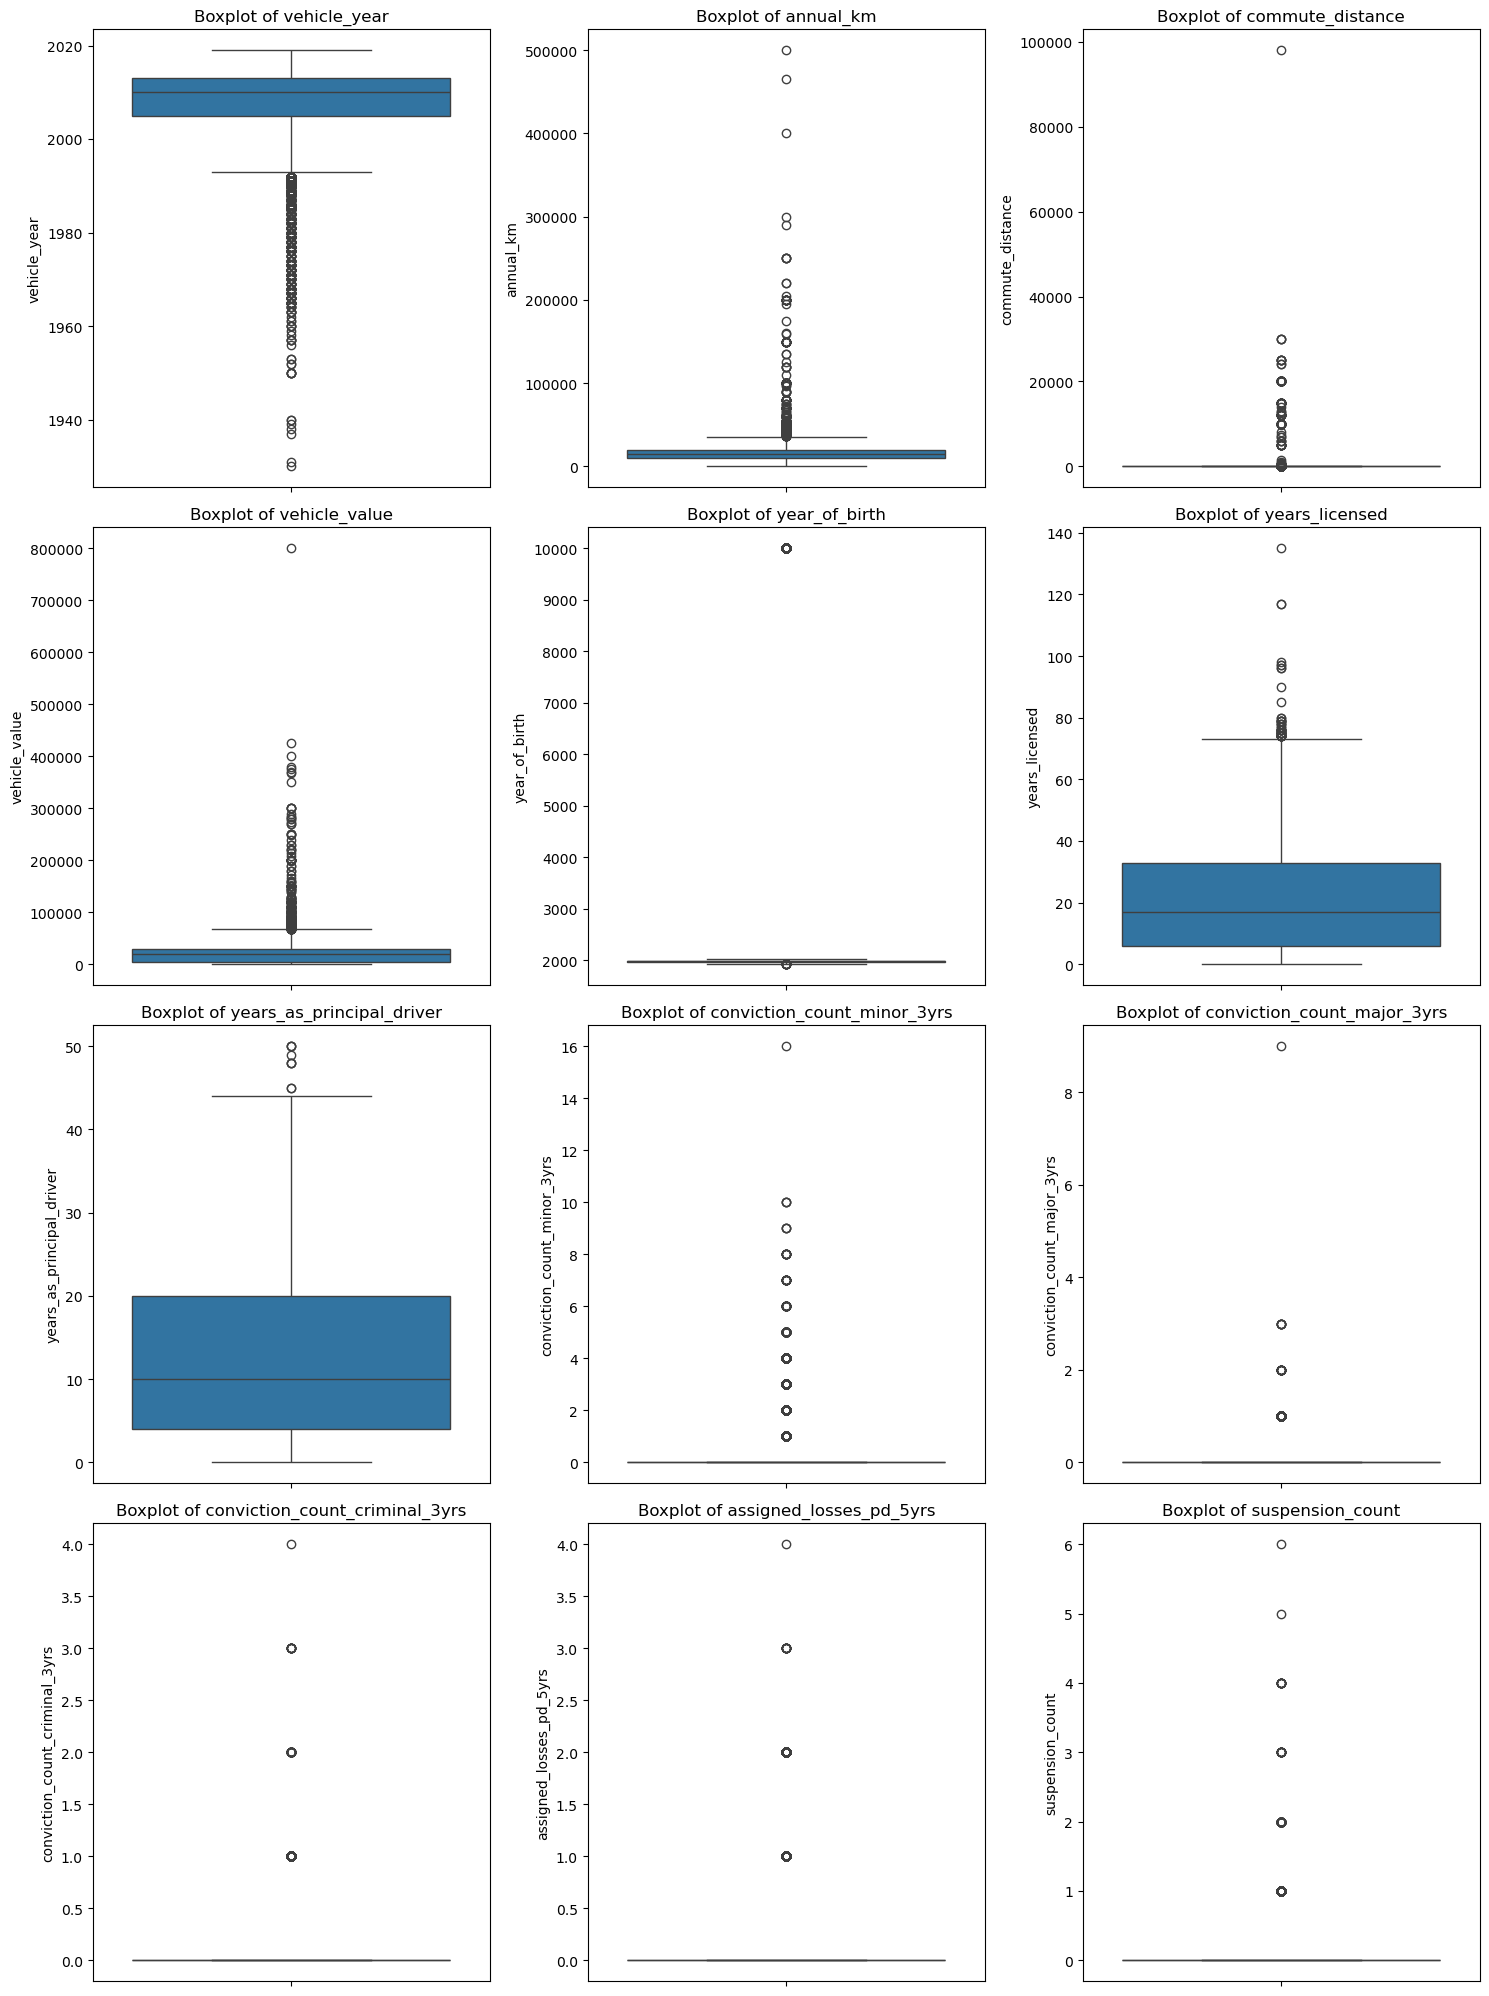

In [31]:
# Picking numerical Columns
num_cols = train_df.select_dtypes(include=['float64', 'number']).columns
num_cols = num_cols[num_cols != 'is_bound']

# Creating Subplots Grid

fig, axes = plt.subplots(nrows=(len(num_cols) // 3) + 1, ncols=3, figsize=(15, 5 * ((len(num_cols) // 3) + 1)))

# Flattening axes for easy iteration
axes = axes.flatten()

# plotting each numeric column against 'is_bound'
for i, col in enumerate(num_cols):
    sns.boxplot(y =train_df[col], ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')

# Hiding any extra subplots where numeric columns are not a multiple of 3
for i in range(len(num_cols), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

There seem to be some odd points for some columns. For instance, the year of birth showing as '9999' and commute distance in thousands of kilometres. Also, individuals younger than 16 to 18 years based on the year of birth column cannot legally drive and most likely do not own a car to be insured. Even if they did possibly due to parents gifting them a car, they could not legally drive it and this particularly group of youngsters with gifted cars would be the exception to the rule. 

Commute distance is the distance travelled to work from the client's house. Even in extreme cases, no one travels over 600 kilometres to work. Hence, these are potential errors in the data. 

Logically following, annual kilometres over 10000 is odd. Even on the extreme end, where a person's professional may be as an Uber driver, annual kilometers on their vehicle would not be over 50,000km. If that variable looked at total kilometers on the car, figures over 100,000 would make sense.



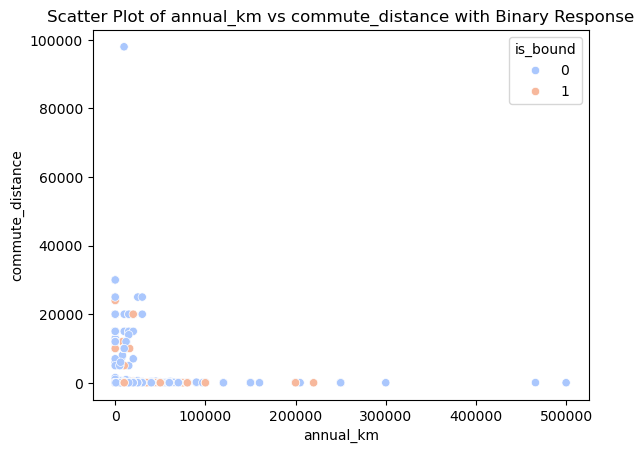

In [32]:
# Create the scatter plot
sns.scatterplot(x='annual_km', y='commute_distance', hue='is_bound', data=train_df, palette='coolwarm', markers=['o', 'X'])

# Add labels and title
plt.xlabel('annual_km')
plt.ylabel('commute_distance')
plt.title('Scatter Plot of annual_km vs commute_distance with Binary Response')

# Show the plot
plt.show()

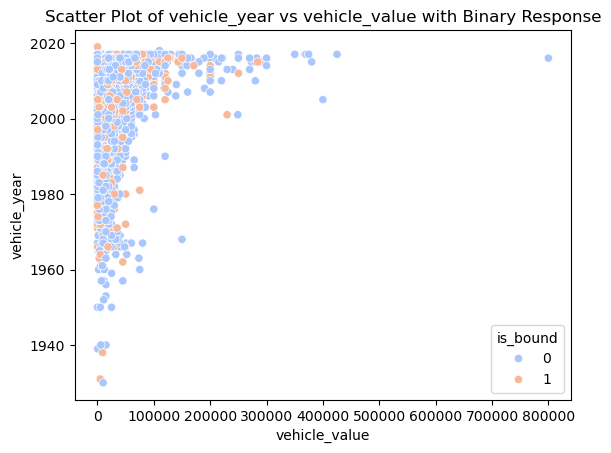

In [33]:
# Create the scatter plot
sns.scatterplot(x='vehicle_value', y='vehicle_year', hue='is_bound', data=train_df, palette='coolwarm', markers=['o', 'X'])

# Add labels and title
plt.xlabel('vehicle_value')
plt.ylabel('vehicle_year')
plt.title('Scatter Plot of vehicle_year vs vehicle_value with Binary Response')

# Show the plot
plt.show()

We drop some of the values below based on them seeming errorneous or being extreme relative to the variable's median

In [34]:
index_to_drop = train_df[train_df['commute_distance']>=601].index
# Dropping the abnormal points from the training data
train_df = train_df.drop(index_to_drop, axis=0)

index_to_drop = train_df[train_df['annual_km']>50000].index
# Dropping the abnormal points from the training data
train_df = train_df.drop(index_to_drop, axis=0)

index_to_drop = train_df[train_df['vehicle_year']<1940].index
# Dropping the abnormal points from the training data
train_df = train_df.drop(index_to_drop, axis=0)

index_to_drop = train_df[train_df['vehicle_value']>=200000].index
# Dropping the abnormal points from the training data
train_df = train_df.drop(index_to_drop, axis=0)

index_to_drop = train_df[train_df['years_licensed']>=80].index
# Dropping the abnormal points from the training data
train_df = train_df.drop(index_to_drop, axis=0)

index_to_drop = train_df[(train_df['year_of_birth']==9999) | (train_df['year_of_birth']>= 2000)].index
# Dropping the abnormal points from the training data
train_df = train_df.drop(index_to_drop, axis=0)

Viewing Variables After dropping rows

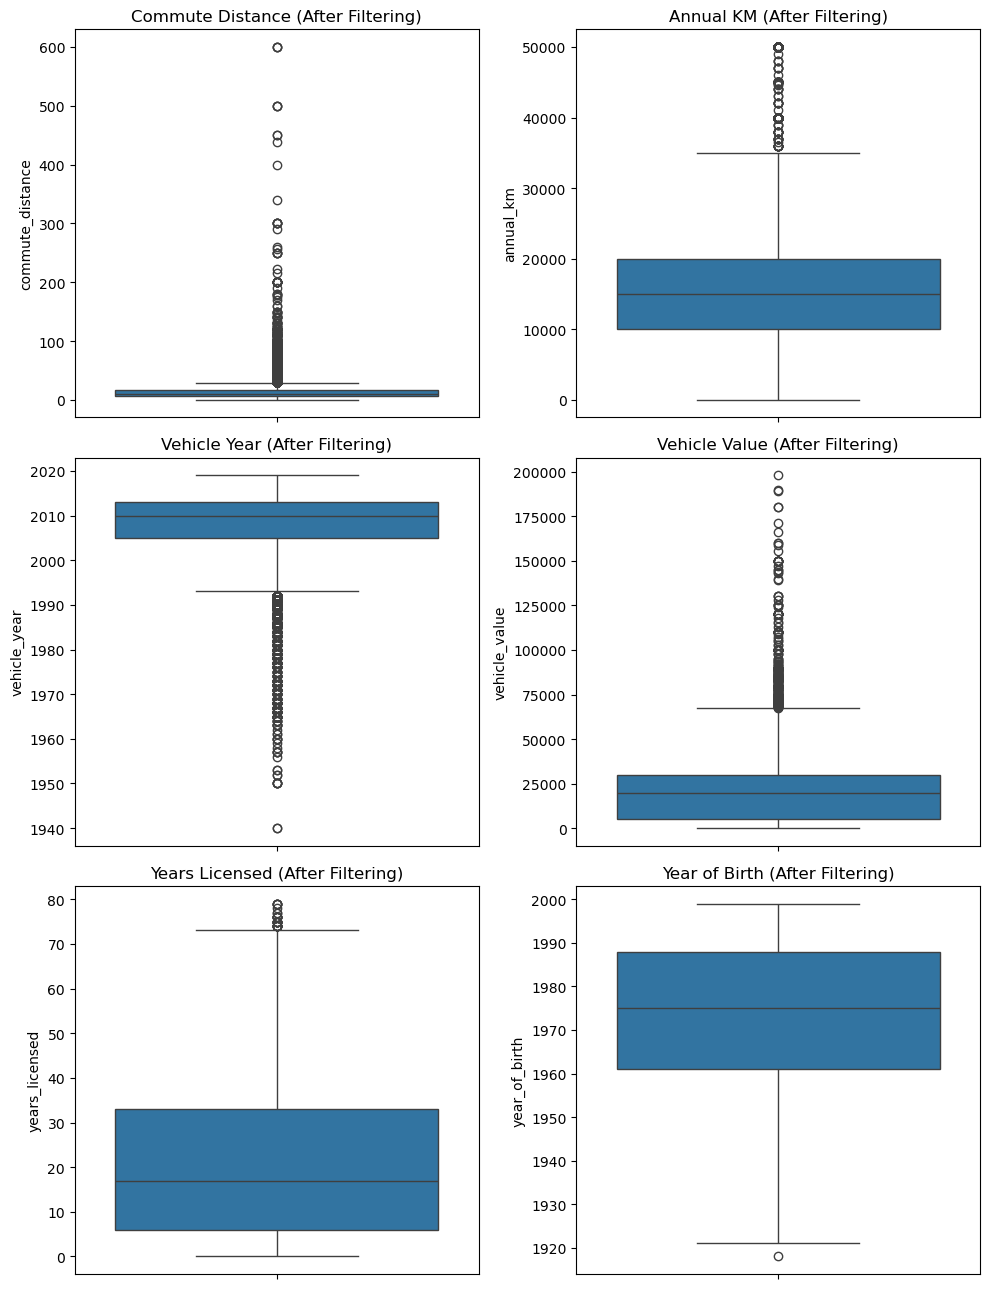

In [37]:
# Set up the figure and axes for the subplots
fig, axes = plt.subplots(3, 2, figsize=(10, 13))

# Plotting Commute Distance
sns.boxplot(y=train_df['commute_distance'], ax=axes[0, 0])
axes[0, 0].set_title('Commute Distance (After Filtering)')

# Plotting Annual KM
sns.boxplot(y=train_df['annual_km'], ax=axes[0, 1])
axes[0, 1].set_title('Annual KM (After Filtering)')

# Plotting Vehicle Year
sns.boxplot(y=train_df['vehicle_year'], ax=axes[1, 0])
axes[1, 0].set_title('Vehicle Year (After Filtering)')
axes[1, 0].tick_params(axis='x', rotation=45)

# Plotting Vehicle Value
sns.boxplot(y=train_df['vehicle_value'], ax=axes[1, 1])
axes[1, 1].set_title('Vehicle Value (After Filtering)')

# Plotting Years Licensed
sns.boxplot(y=train_df['years_licensed'], ax=axes[2, 0])
axes[2, 0].set_title('Years Licensed (After Filtering)')

# Plotting Years Licensed
sns.boxplot(y=train_df['year_of_birth'], ax=axes[2, 1])
axes[2, 1].set_title('Year of Birth (After Filtering)')

# Adjust layout for better spacing
plt.tight_layout()

# Display all the plots
plt.show()

Combining both datasets to fill in missing values

In [40]:
# Concatenate the datasets
full_df = pd.concat([train_df, test_df], ignore_index=True)

# View the combined data
full_df

,quote_date,vehicle_year,vehicle_make,vehicle_model,annual_km,commute_distance,marking_system,tracking_system,vehicle_ownership,vehicle_value,...,years_as_principal_driver,multi_product,marital_status,occupation,conviction_count_minor_3yrs,conviction_count_major_3yrs,conviction_count_criminal_3yrs,assigned_losses_pd_5yrs,suspension_count,is_bound
0,2016-01-02,2006,VOLKSWAGEN,JETTA 2.5 4P,10000.0,NaN,NaN,NaN,Owned,3000.0,...,10.0,No,Married,Trades,0,0,0,0,0,0.0
1,2016-01-02,2017,HYUNDAI,ELANTRA GL 4DR,20000.0,NaN,NaN,NaN,Owned,1.0,...,NaN,No,Married,Not Known,0,0,0,0,0,0.0
2,2016-01-02,2015,CHEVROLET TRUCK/VAN,SILVERADO 2500 HD LT CREW CAB 4WD,15000.0,NaN,NaN,NaN,NaN,NaN,...,NaN,No,Single,Not Known,0,0,0,0,0,0.0
3,2016-01-02,2010,TOYOTA,COROLLA CE 4DR,20000.0,20.0,NaN,NaN,NaN,NaN,...,NaN,Yes,Single,Not Known,0,0,0,0,0,0.0
4,2016-01-04,2013,HONDA,CIVIC LX 4DR,30000.0,30.0,NaN,NaN,NaN,NaN,...,NaN,Yes,Single,Not Known,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115979,2017-02-27,2012,HONDA,CIVIC DX 4DR,20000.0,16.0,NaN,NaN,NaN,NaN,...,NaN,Yes,Single,Not Known,0,0,0,0,0,NaN
115980,2017-02-27,2011,BMW,323i 4DR,10000.0,8.0,NaN,NaN,NaN,12418.0,...,NaN,Yes,Married,Not Known,0,0,0,0,0,NaN
115981,2017-02-27,2007,HONDA TRUCK/VAN,ODYSSEY LX,15000.0,5.0,NaN,NaN,NaN,NaN,...,NaN,Yes,Married,Not Known,0,0,0,0,0,NaN
115982,2017-02-27,2014,HONDA TRUCK/VAN,CRV,12000.0,13.0,NaN,NaN,NaN,35000.0,...,NaN,Yes,Single,Not Known,0,0,0,0,0,NaN


In [41]:
# Function to obtain percentages of missing values
def percent_missing(df):
    nan_percent = 100 * df.isnull().sum() / len(df)
    nan_percent = nan_percent[nan_percent > 0].sort_values()

    return nan_percent

# Function to plot out missing value percentages by column
def show_percent_missing(df):
    nan_percent = percent_missing(df)

    sns.barplot(x=nan_percent.index, y=nan_percent)
    plt.xticks(rotation=90)
    plt.ylabel('Missing Percentage %')
    plt.xlabel('Variables')

Displaying missing values

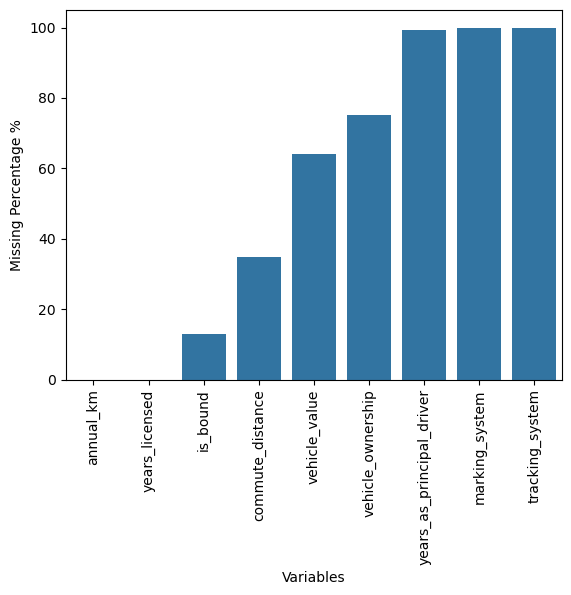

In [43]:
show_percent_missing(full_df)

Over 80% of values missing for 'years as principal driver', 'marking system' and 'tracking system'. These variables will be dropped and the remaining columns with missing values will be handled on a case by case situation

In [44]:
# Dropping Columns With Missing Values Over 80% on training data
full_df.drop(columns=['years_as_principal_driver', 'marking_system','tracking_system'], axis =1, inplace=True)
full_df.head()

,quote_date,vehicle_year,vehicle_make,vehicle_model,annual_km,commute_distance,vehicle_ownership,vehicle_value,vehicle_use,gender,...,years_licensed,multi_product,marital_status,occupation,conviction_count_minor_3yrs,conviction_count_major_3yrs,conviction_count_criminal_3yrs,assigned_losses_pd_5yrs,suspension_count,is_bound
0,2016-01-02,2006,VOLKSWAGEN,JETTA 2.5 4P,10000.0,NaN,Owned,3000.0,Pleasure,Male,...,25.0,No,Married,Trades,0,0,0,0,0,0.0
1,2016-01-02,2017,HYUNDAI,ELANTRA GL 4DR,20000.0,NaN,Owned,1.0,Business,Male,...,10.0,No,Married,Not Known,0,0,0,0,0,0.0
2,2016-01-02,2015,CHEVROLET TRUCK/VAN,SILVERADO 2500 HD LT CREW CAB 4WD,15000.0,NaN,NaN,NaN,Pleasure,Male,...,39.0,No,Single,Not Known,0,0,0,0,0,0.0
3,2016-01-02,2010,TOYOTA,COROLLA CE 4DR,20000.0,20.0,NaN,NaN,Commute,Male,...,3.0,Yes,Single,Not Known,0,0,0,0,0,0.0
4,2016-01-04,2013,HONDA,CIVIC LX 4DR,30000.0,30.0,NaN,NaN,Commute,Male,...,2.0,Yes,Single,Not Known,0,0,0,0,0,0.0


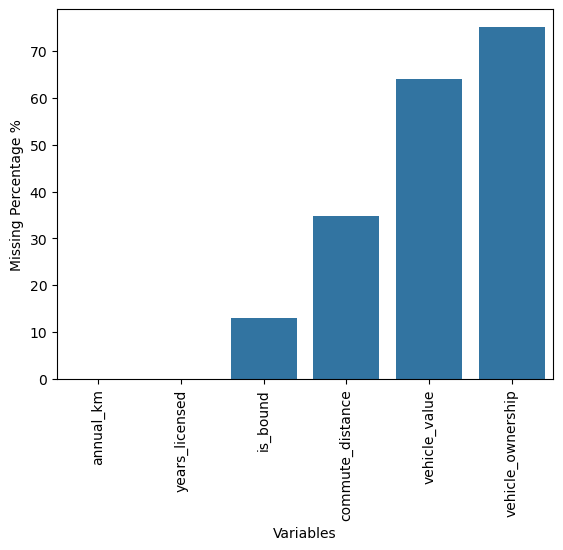

In [45]:
show_percent_missing(full_df)

We zoom in the plot below to display annual kilometers and years licensed better

(0.0, 0.03)

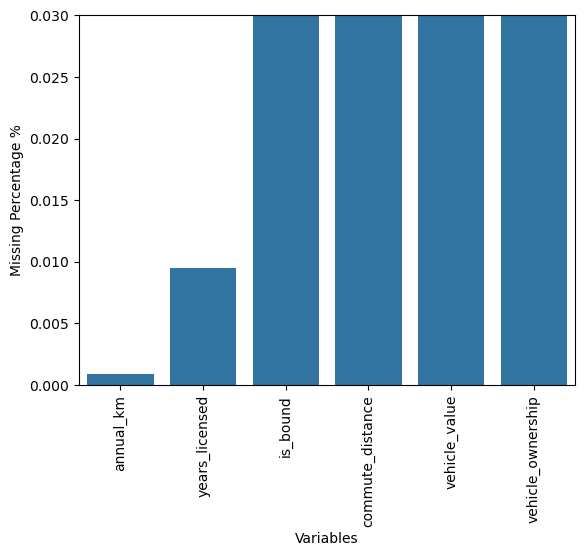

In [47]:
nan_percent = percent_missing(full_df)

sns.barplot(x=nan_percent.index, y=nan_percent)
plt.xticks(rotation=90)
plt.ylabel('Missing Percentage %')
plt.xlabel('Variables')
plt.ylim(0,0.03)

In [48]:
# Filling missing values with the median
full_df["annual_km"] = full_df["annual_km"].fillna(full_df["annual_km"].median())

# Filling missing values with the mode of vehicle ownership which is the category 'owned'
full_df["vehicle_ownership"] = full_df["vehicle_ownership"].fillna(full_df["vehicle_ownership"].mode()[0])


# Filling missing values of years licensed with median years licensed of each year_of_birth
full_df['years_licensed'] = full_df.groupby('year_of_birth')['years_licensed'].transform(lambda value: value.fillna(value.median()))

# Filling missing values of vehicle value with median vehicle value of each vehicle make
full_df['vehicle_value'] = full_df.groupby('vehicle_make')['vehicle_value'].transform(lambda value: value.fillna(value.median()))

# Filling remaining missing values with median of vehicle value for rows with blank vehicle model
full_df['vehicle_value'] = full_df['vehicle_value'].fillna(full_df['vehicle_value'].median())


# Indexing retirees and unemployed to fill their commute distances with zeros as retirees and unemployed should not have any commute distance to work from home.
index_to_fill = full_df[(full_df['occupation'] == 'Retired') | (full_df['occupation'] == 'Unemployed')].index

# Replacing commute distances of indexed group with zero
full_df.loc[index_to_fill, 'commute_distance'] = 0

# Filling remaining missing values with median of each occupation
full_df['commute_distance'] = full_df.groupby('occupation')['commute_distance'].transform(lambda value: value.fillna(value.median()))

# Filling remaining missing values with median of commute_distance for rows with blank occupation
full_df['commute_distance'] = full_df['commute_distance'].fillna(full_df['commute_distance'].median());

In [49]:
# Confirming all missing values are filled except is_bound which have missing values due to the joined data from test dataset
full_df.isnull().sum()

quote_date                            0
vehicle_year                          0
vehicle_make                          0
vehicle_model                         0
annual_km                             0
commute_distance                      0
vehicle_ownership                     0
vehicle_value                         0
vehicle_use                           0
gender                                0
year_of_birth                         0
postal_code                           0
area_code                             0
years_licensed                        0
multi_product                         0
marital_status                        0
occupation                            0
conviction_count_minor_3yrs           0
conviction_count_major_3yrs           0
conviction_count_criminal_3yrs        0
assigned_losses_pd_5yrs               0
suspension_count                      0
is_bound                          15114
dtype: int64

Before obtaining dummies, we do frequency encoding on vehicle model variable as it has too many unique categories (over 6000)

In [50]:
# Calculate frequency for each category
frequency_encoding = full_df['vehicle_model'].value_counts()

# Map the frequencies back to the original column
full_df['vehicle_model'] = full_df['vehicle_model'].map(frequency_encoding)

We also regroup the vehicle make column as many unnecessary spelling mistakes were made for the same vehicle make. Doing this would avoid creating unnecessary dummy variables for the same vehicle make that was spelt slightly differently when inputting the data.

In [51]:
# Groupoing vehicle makes
category_mapping = {'1FTFW1EF8BFA01523': 'FORD', 'FORD F150': 'FORD', 'F150': 'FORD', 'F250': 'FORD',
                    'FORD EDGE': 'FORD', 'FORD FOCUS': 'FORD', 'FORD MUSTANG': 'FORD', 'FORD TRUCK/VAN': 'FORD',
                    'FORD CAMION/VAN': 'FORD', '2XXXXXXXXXXXXXXXXXX': 'NISSAN','PASSAT': 'NISSAN',
                    'NISSAN CAMION/VAN': 'NISSAN', 'NISSAN TRUCK/VAN': 'NISSAN', 'NISSSAN': 'NISSAN', 'NISAN': 'NISSAN',
                    'ACCURA': 'ACURA', 'ACURA CAMION/VAN': 'ACURA', 'ACURA TRUCK/VAN': 'ACURA', 'ALFA': 'ALFA ROMEO',
                    'AMERICAN MOTORS': 'AMC', 'ARTIC CAT': 'ARCTIC CAT', 'ARTCIT CAT': 'ARCTIC CAT',
                    'AUDI TRUCK/VAN': 'AUDI', 'BENTLEY TRUCK/VAN': 'BENTLEY', 'BMW CAMION/VAN': 'BMW',
                    'BMW TRUCK/VAN': 'BMW', 'BOMBADIER': 'BOMBARDIER', 'BUICK TRUCK/VAN': 'BUICK',
                    'CADILLAC CAMION/VAN': 'CADILLAC', 'CADILLAC TRUCK/VAN': 'CADILLAC', 'CADILLIAC': 'CADILLAC',
                    'CEVROLET': 'CHEVROLET', 'CHEVY': 'CHEVROLET', 'CHCVIOE': 'CHEVROLET', 'CHEV': 'CHEVROLET',
                    'CHEVRELOT': 'CHEVROLET', 'CHEVROLE': 'CHEVROLET', 'CHEVROLER': 'CHEVROLET',
                    'CHEVROLET CAMION/VAN': 'CHEVROLET', 'CHEVROLET TRUCK/VAN': 'CHEVROLET', 'CHEV CRUZ': 'CHEVROLET',
                    'CHRSYLER': 'CHRYSLER', 'CHRYLSER': 'CHRYSLER', 'CHRYSLER TRUCK/VAN': 'CHRYSLER',
                    'CRYSLER': 'CHRYSLER', 'DODDGE': 'DODGE', 'DODGE GRAND CARAVAN': 'DODGE', 'DODGE RAM': 'DODGE',
                    'DODGE/RAM': 'DODGE', 'DODGE/RAM CAMION/VAN': 'DODGE', 'DODGE/RAM TRUCK/VAN': 'DODGE',
                    'HONDA CIVIC': 'HONDA', 'HONDA 650': 'HONDA', 'HONDA ACCORD': 'HONDA', 'HONDA CAMION/VAN': 'HONDA',
                    'HONDA  CIVIC': 'HONDA', 'HONDA CR- V': 'HONDA', 'HONDA TRUCK/VAN': 'HONDA', 'HONODA': 'HONDA',
                    'VOLKSWAGON': 'VOLKSWAGEN', 'VOLKSWAGON JETTA': 'VOLKSWAGEN', 'VOLLKS': 'VOLKSWAGEN',
                    'VW': 'VOLKSWAGEN', 'WV': 'VOLKSWAGEN', 'VOLKS': 'VOLKSWAGEN',
                    'VOLKSWAGEN CAMION/VAN': 'VOLKSWAGEN', 'VOLKWAGEN TRUCK/VAN': 'VOLKSWAGEN',
                    'VOLKSWAGEN CAMION/VAN': 'VOLKSWAGEN', 'VOLKSWAGENJAVASCRIPT:VOID(0)': 'VOLKSWAGEN',
                    'TOTOTA': 'TOYOTA', 'TOYOATA': 'TOYOTA', 'TOYOTA CAMION/VAN': 'TOYOTA',
                    'TOYOTA HIGHLANDER': 'TOYOTA', 'TOYOTA TRUCK/VAN': 'TOYOTA', 'TOYOTO': 'TOYOTA', 'TOYTO': 'TOYOTA',
                    'PORCHE': 'PORSCHE', 'PORSCHE CAMION/VAN': 'PORSCHE', 'PORSCHE TRUC/VAN': 'PORSCHE',
                    'PROSCHE': 'PORSCHE', 'PONITAC': 'PONTIAC', 'PONTAIC': 'PONTIAC', 'PONTIAC CAMION/VAN': 'PONTIAC',
                    'PONTIAC TRUCK/VAN': 'PONTIAC', 'PONTIIAC': 'PONTIAC', 'PLYMONTH': 'PLYMOUTH',
                    'PLYMOUTH TRUCK/VAN': 'PLYMOUTH', 'MITIBUSHI': 'MITSUBISHI', 'HUNDAI': 'HYUNDAI',
                    'HUNDAY': 'HYUNDAI', 'HYNDAI': 'HYUNDAI', 'HYNDEI': 'HYUNDAI', 'HYUANDAI': 'HYUNDAI',
                    'HYUNDAI CAMION/VAN': 'HYUNDAI', 'HYUNDAI TRUCK/VAN': 'HYUNDAI', 'HYUNDIA': 'HYUNDAI',
                    'INFINITI TRUCK/VAN': 'INFINITI', 'INFINITY': 'INFINTI', 'INFINTI': 'INFINITI',
                    'JEEP WRANGLER': 'JEEP', 'JEPP': 'JEEP', 'LAND ROVER': 'LANDROVER', 'MAZDA 3': 'MAZDA',
                    'MAZDA CAMION/VAN': 'MAZDA', 'MAZDA TRUCK/VAN': 'MAZDA', 'MAZDA3': 'MAZDA', 'MAZDS': 'MAZDA',
                    'MECEDEZ': 'MERCEDES', 'MERCEDES BENZ': 'MERCEDES', 'MERCEDES-BENZ': 'MERCEDES',
                    'MERCEDES-BENZ TRUCK': 'MERCEDES'}


full_df['vehicle_make'] = full_df['vehicle_make'].map(category_mapping).fillna(full_df['vehicle_make'])

In [52]:
# Defining Categorical columns. Numeric columns excluding is_bound were obtained above
num_cols
cat_cols = full_df.select_dtypes(include='object').columns


full_df[cat_cols] = full_df[cat_cols].astype(str)
full_df[cat_cols] = full_df[cat_cols].apply(lambda x: x.astype(str))

In [53]:
# Obtainig Dummies
full_df = pd.get_dummies(full_df, drop_first=True)

full_df.tail()

,quote_date,vehicle_year,vehicle_model,annual_km,commute_distance,vehicle_value,year_of_birth,years_licensed,conviction_count_minor_3yrs,conviction_count_major_3yrs,...,occupation_Professional/Health,occupation_Professional/Other,occupation_Professional/Social,occupation_Retired,occupation_Sales,occupation_Service Work,occupation_Student,occupation_Trades,occupation_Tradesman,occupation_Unemployed
115979,2017-02-27,2012,1441,20000.0,16.0,18000.0,1988,9.0,0,0,...,False,False,False,False,False,False,False,False,False,False
115980,2017-02-27,2011,38,10000.0,8.0,12418.0,1973,27.0,0,0,...,False,False,False,False,False,False,False,False,False,False
115981,2017-02-27,2007,178,15000.0,5.0,28000.0,1961,32.0,0,0,...,False,False,False,False,False,False,False,False,False,False
115982,2017-02-27,2014,29,12000.0,13.0,35000.0,1991,9.0,0,0,...,False,False,False,False,False,False,False,False,False,False
115983,2017-02-27,2017,32,25000.0,23.0,20000.0,1959,41.0,0,0,...,False,True,False,False,False,False,False,False,False,False


There are 1614 columns. Before standardizing the numeric columns, we drop the quote_date column and obtain all numerical columns and exclude is_bound, the response variable

In [54]:
full_df.drop(columns = 'quote_date', axis=1, inplace = True)


num_cols = list(full_df.select_dtypes(include=['float64', 'int64']).columns)

num_cols.remove('is_bound')
num_cols

['vehicle_year',
 'vehicle_model',
 'annual_km',
 'commute_distance',
 'vehicle_value',
 'year_of_birth',
 'years_licensed',
 'conviction_count_minor_3yrs',
 'conviction_count_major_3yrs',
 'conviction_count_criminal_3yrs',
 'assigned_losses_pd_5yrs',
 'suspension_count']

# Standardizing Numeric Variables

In [55]:
scaler = StandardScaler()

full_df[num_cols] = scaler.fit_transform(full_df[num_cols])

full_df.head()

,vehicle_year,vehicle_model,annual_km,commute_distance,vehicle_value,year_of_birth,years_licensed,conviction_count_minor_3yrs,conviction_count_major_3yrs,conviction_count_criminal_3yrs,...,occupation_Professional/Health,occupation_Professional/Other,occupation_Professional/Social,occupation_Retired,occupation_Sales,occupation_Service Work,occupation_Student,occupation_Trades,occupation_Tradesman,occupation_Unemployed
0,-0.514575,-0.620318,-0.668117,-0.209912,-1.488340,-0.006557,0.261805,-0.315901,-0.051373,-0.070281,...,False,False,False,False,False,False,False,True,False,False
1,1.384743,2.115033,0.734816,-0.209912,-1.736455,-0.131255,-0.663484,-0.315901,-0.051373,-0.070281,...,False,False,False,False,False,False,False,False,False,False
2,1.039413,-0.564044,0.033349,-0.209912,0.083580,-0.116585,1.125409,-0.315901,-0.051373,-0.070281,...,False,False,False,False,False,False,False,False,False,False
3,0.176086,3.919842,0.734816,0.599788,-0.412816,0.066795,-1.095286,-0.315901,-0.051373,-0.070281,...,False,False,False,False,False,False,False,False,False,False
4,0.694082,3.244546,2.137749,1.409489,-0.247351,0.044790,-1.156972,-0.315901,-0.051373,-0.070281,...,False,False,False,False,False,False,False,False,False,False


In [56]:
full_df['is_bound']

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
115979    NaN
115980    NaN
115981    NaN
115982    NaN
115983    NaN
Name: is_bound, Length: 115984, dtype: float64

# MODELLING AND MODEL TUNING

# Model One

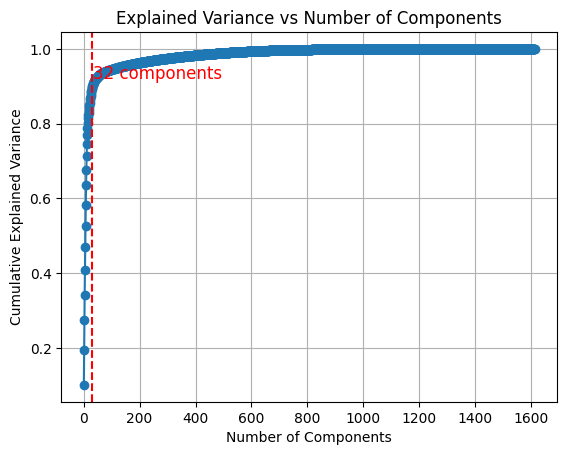

In [ ]:

# Applying PCA with different numbers of components
pca = PCA()

# Obtainig all predictors
x_cols = full_df.loc[:, full_df.columns != 'is_bound']

pca.fit(x_cols)

# Cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# elbow point
elbow_point = np.argmax(cumulative_variance >= 0.90) + 1

#plotting cumulative variance for each additional component
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o',
         label='Cumulative Explained Variance')
plt.axvline(x=elbow_point, color='r', linestyle='--',
            label=f'Elbow at {elbow_point} components')

# display number of components at elbow point
plt.text(elbow_point + 0.2, cumulative_variance[elbow_point - 1] + 0.02,
         f'{elbow_point} components', color='red', fontsize=12)

plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs Number of Components')
plt.grid(True)
plt.show()

In [ ]:
# Find the number of components that explain at least 95% of the variance
threshold = 0.90
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Get the number of components that reaches the threshold
n_components_90 = np.argmax(cumulative_variance >= threshold) + 1
print(f"Number of components to explain at least 90% variance: {n_components_90}")

Number of components to explain at least 90% variance: 32


In [ ]:
# Setting folds to be used for cross-validation
K = 5
kfold = skm.KFold(K,
                  random_state=42,
                  shuffle=True)

In [ ]:
condition = full_df['is_bound'].isnull()
train_data = full_df[~condition]

test_data = full_df[condition]

In [ ]:
test_data.drop(columns = 'is_bound', axis=1, inplace = True)
test_data.head()

<ipython-input-42-4f593ac623b9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(columns = 'is_bound', axis=1, inplace = True)


,vehicle_year,vehicle_model,annual_km,commute_distance,vehicle_value,year_of_birth,years_licensed,conviction_count_minor_3yrs,conviction_count_major_3yrs,conviction_count_criminal_3yrs,...,occupation_Professional/Health,occupation_Professional/Other,occupation_Professional/Social,occupation_Retired,occupation_Sales,occupation_Service Work,occupation_Student,occupation_Trades,occupation_Tradesman,occupation_Unemployed
100870,-1.205236,-0.596201,-0.668117,-0.695733,-0.247351,0.125477,-0.848542,-0.315901,-0.051373,-0.070281,...,False,False,False,False,False,False,False,False,False,False
100871,0.176086,1.178461,-0.668117,-0.209912,0.497243,0.081466,-0.478426,-0.315901,-0.051373,-0.070281,...,False,False,False,False,False,False,False,False,False,False
100872,1.384743,-0.580122,-0.808410,-0.776703,4.220212,-0.065239,0.755293,-0.315901,-0.051373,-0.070281,...,False,False,False,False,False,False,False,False,False,False
100873,0.694082,-0.141984,-0.668117,-0.209912,2.813757,0.118142,-0.725170,-0.315901,-0.051373,-0.070281,...,False,False,False,False,False,False,False,False,False,False
100874,0.866747,0.810666,0.734816,-0.209912,-0.294963,0.140147,-1.033600,-0.315901,-0.051373,-0.070281,...,False,False,False,False,False,False,True,False,False,False


In [ ]:
# Obtaining predictors and response variable from pca_train
x_train = train_data.loc[:, train_data.columns != 'is_bound']
y_train = train_data['is_bound']
y_train

,is_bound
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
100865,0.0
100866,0.0
100867,0.0
100868,1.0


In [ ]:
# Splitting the train dataset to perform a CV logistic regression.
logit_x_train, x_valid, logit_y_train, y_valid = skm.train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Modelling Approach A

In [ ]:
# This takes two minutes to run
num_components_range = range(32, 42)

# Storing cv results
cv_results = []

for num_components in num_components_range:
  # for threshold in thresholds:
  pipeline = Pipeline([
      ('pca', PCA(n_components=num_components)),
      ('logreg', LogisticRegression(solver='liblinear', penalty='l1', random_state=42))
  ])
  print(num_components)

  # performing cross-validation using ROC AUC as scoring metric
  auc_scores = cross_val_score(pipeline, logit_x_train, logit_y_train, cv=kfold, scoring='roc_auc')
  cv_results.append(auc_scores.mean())

  best_index = np.argmax(cv_results)
  print(best_index)
  best_num_components = num_components_range[best_index]
  best_auc = cv_results[best_index]

  print(f'component: {num_components}, AUC: {best_auc:.5f}')


32
0
component: 32, AUC: 0.62320
33
1
component: 33, AUC: 0.62337
34
2
component: 34, AUC: 0.62371
35
3
component: 35, AUC: 0.62645
36
4
component: 36, AUC: 0.62645
37
4
component: 37, AUC: 0.62645
38
4
component: 38, AUC: 0.62645
39
4
component: 39, AUC: 0.62645
40
4
component: 40, AUC: 0.62645
41
9
component: 41, AUC: 0.62646


In [ ]:
# Determining optimal number of components based on cross-validation
optimal_component = num_components_range[np.argmax(cv_results)]
best_auc = np.max(cv_results)
print(f'Optimal number of PCA components: {optimal_component}, AUC: {best_auc:.4f}')

Optimal number of PCA components: 41, AUC: 0.6265


Based on the optimala number of components, I create a dataset and rerun cross-validated Logistic Regression using the new pca dataset.

In [ ]:
pca = PCA(n_components=optimal_component)

x_cols = full_df.loc[:, full_df.columns != 'is_bound']

pca_result = pca.fit_transform(x_cols)

# Creating a new dataframe to use for further analysis
pca_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(optimal_component)])

# Adding IS_BOUND to the new dataset
pca_df = pd.concat([pca_df, full_df['is_bound'].reset_index(drop=True)], axis=1)

In [ ]:
condition = pca_df['is_bound'].isnull()
pca_train_data = pca_df[~condition]

pca_test_data = pca_df[condition]

In [ ]:
# Obtaining predictors and response variable from pca_train
x_pca_train = pca_train_data.loc[:, pca_train_data.columns != 'is_bound']
y_pca_train = pca_train_data['is_bound']

In [ ]:
pca_test_data

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,is_bound
100870,-0.123889,0.807336,-1.351346,-0.114294,-0.417882,0.781379,0.198376,-0.709682,-0.637308,0.418919,...,-0.093670,-0.141585,0.336910,0.810107,0.115634,0.087118,-0.400229,0.014798,0.006917,NaN
100871,-0.030144,-0.147891,-0.218341,-1.197701,0.593318,0.052931,0.163158,-0.196849,-0.097607,0.795995,...,-0.008428,0.009815,-0.044842,-0.054137,-0.028503,-0.000277,-0.023084,0.022890,0.030734,NaN
100872,-1.003338,-0.717677,3.403577,-1.367394,-0.947985,1.140688,0.437538,-0.650018,-0.380931,1.475161,...,-0.048527,-0.127564,-0.091748,0.001072,-0.079350,-0.104752,-0.053895,0.096159,-0.050584,NaN
100873,-0.010947,-0.675616,1.483958,-1.296859,-0.572515,1.117763,0.410066,-0.798388,-0.640359,1.603706,...,-0.075646,-0.079556,0.063369,0.188171,-0.023019,-0.088577,0.146493,0.085773,-0.190652,NaN
100874,0.882604,-0.853943,-0.476599,-1.010395,0.737694,0.157731,0.183834,-0.336838,-0.409919,-0.597231,...,-0.014039,0.053694,0.019091,-0.087435,-0.023659,0.023464,-0.023845,0.030475,0.025455,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115979,0.949580,-1.062007,-0.712644,-1.292003,1.697291,-0.625648,0.058745,0.201851,0.110922,0.190933,...,-0.011781,0.029393,0.013356,-0.053696,-0.016479,0.012111,-0.021477,0.051413,0.007172,NaN
115980,-0.717723,0.378978,-0.030716,0.138039,0.032911,0.212161,0.011499,-0.063490,-0.110204,-0.692468,...,0.059188,0.111653,-0.080921,-0.008237,-0.028137,0.115191,0.034192,-0.096264,0.648865,NaN
115981,-0.732506,0.174362,0.568064,0.212175,0.061314,0.175591,0.048399,0.011146,0.011847,0.016463,...,-0.039378,-0.119493,-0.018314,-0.026619,-0.005938,-0.021627,-0.023751,0.049628,-0.035314,NaN
115982,0.166311,-0.641652,0.668219,-0.746428,-0.300376,0.888824,0.272029,-0.647533,-0.672143,0.418895,...,-0.063936,-0.112598,-0.012023,-0.046300,-0.031415,-0.052439,-0.042717,0.079452,-0.021837,NaN


In [ ]:
# Splitting the train dataset to perform a CV logistic regression.
pca_x_train, x_valid, pca_y_train, y_valid = skm.train_test_split(x_pca_train, y_pca_train, test_size=0.2, random_state=42)

The threshold where validation adevertising revenue is highest: 0.16


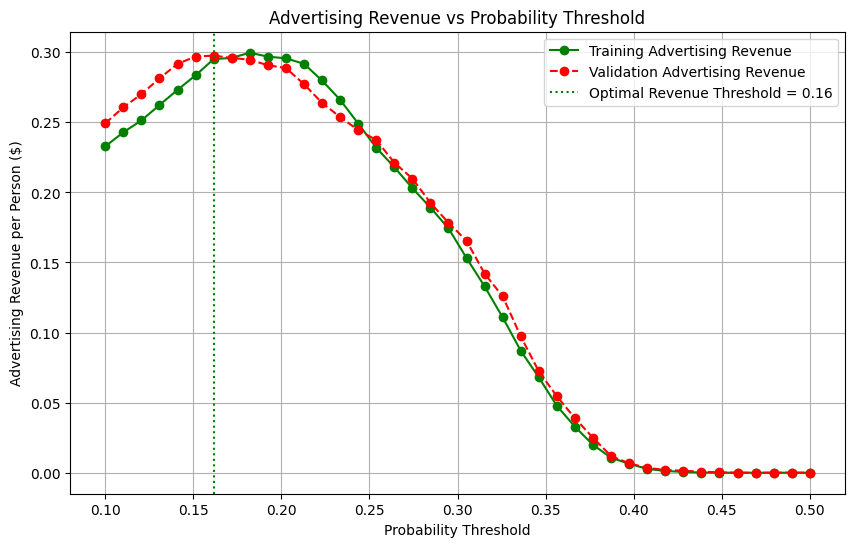

In [ ]:
# Initializing logistic regression model
model = LogisticRegressionCV(cv=kfold, scoring='roc_auc', penalty='l1',
                             max_iter=1000, solver='liblinear')
# Fitting model
model.fit(pca_x_train, pca_y_train)

# defining thresholds
thresholds = np.linspace(0.1, 0.5, 40)

# list of training and testing ad revenues per threshold
ad_rev_per_person_logit_train = []
ad_rev_per_person_val = []


# Performing cross-validated logistic regression with PCA dataset
for threshold in thresholds:

    # Predicting probabilities on training set
    y_train_pred_prob = model.predict_proba(pca_x_train)[:, 1]
    y_train_pred = (y_train_pred_prob >= threshold).astype(int)

    # Calculating False Negative Rate and False Positive Rate for training set
    tn, fp, fn, tp = confusion_matrix(pca_y_train, y_train_pred).ravel()

    # Computing training advertising revenue
    num_train_ones = np.sum(y_train_pred == 1)
    ad_rev_per_person_train = ((5.5 * tp) - num_train_ones) / len(logit_y_train)
    ad_rev_per_person_logit_train.append(ad_rev_per_person_train)

    # Predicting probabilities on validation set
    y_valid_pred_prob = model.predict_proba(x_valid)[:, 1]
    y_valid_pred = (y_valid_pred_prob >= threshold).astype(int)

    # Calculating False Negative Rate and False Positive Rate for validation set
    tn, fp, fn, tp = confusion_matrix(y_valid, y_valid_pred).ravel()

    # Computing validation advertising revenue
    num_valid_ones = np.sum(y_valid_pred == 1)
    ad_rev_per_person_valid = ((5.5 * tp) - num_valid_ones) / len(y_valid)
    ad_rev_per_person_val.append(ad_rev_per_person_valid)

# Interpolating FNR and FPR curves for the validation set
train_ad_interp = interp1d(thresholds, ad_rev_per_person_logit_train, kind='linear')
val_ad_interp = interp1d(thresholds, ad_rev_per_person_val, kind='linear')

# Generating a finer range of thresholds for finding intersections
fine_thresholds = np.linspace(thresholds.min(), thresholds.max(), 500)
train_fine = train_ad_interp(fine_thresholds)
val_fine = val_ad_interp(fine_thresholds)

# Finding the highest revenue point
max_index= np.argmax(val_fine)
revenue_threshold = fine_thresholds[max_index]
max_valid_revenue = val_fine[max_index]  # FNR and FPR at intersection

# Print the optimal threshold
print(f"The threshold where validation adevertising revenue is highest: {revenue_threshold:.2f}")

# Plotting the FNR and FPR for each threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, ad_rev_per_person_logit_train, label='Training Advertising Revenue', marker='o', color='green')
plt.plot(thresholds, ad_rev_per_person_val, label='Validation Advertising Revenue', marker='o', color='red', linestyle='--')

# Mark the optimal threshold on the plot
plt.axvline(revenue_threshold, color='green', linestyle=':', label=f'Optimal Revenue Threshold = {revenue_threshold:.2f}')

# Labels and titles
plt.xlabel('Probability Threshold')
plt.ylabel('Advertising Revenue per Person ($)')
plt.title('Advertising Revenue vs Probability Threshold')
plt.legend()
plt.grid(True)
plt.show()


The threshold where validation FNR and FPR intersect is approximately: 0.22


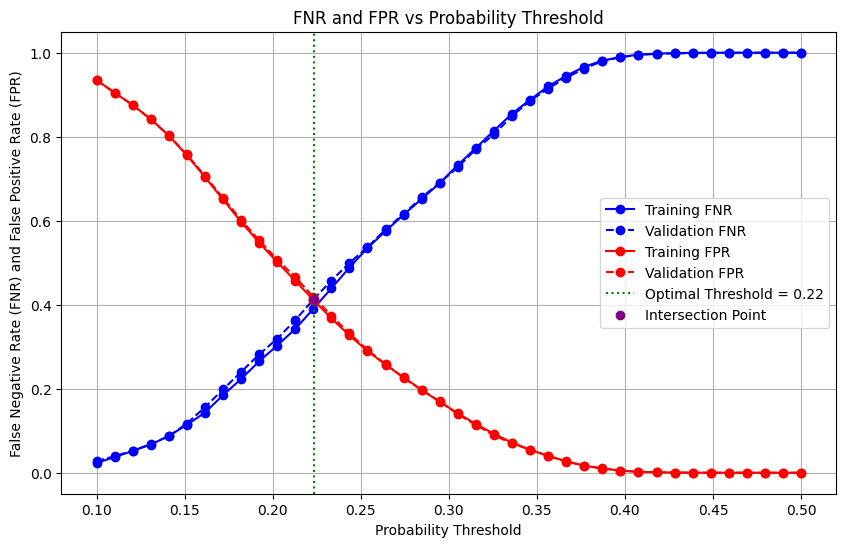

In [ ]:
# Creating thresholds and setting up variables to use in logistic regression
thresholds = np.linspace(0.1, 0.5, 40)
train_fnrs = []
train_fnps = []
valid_fnrs = []
valid_fnps = []


# Performing cross-validated logistic regression with PCA dataset
for threshold in thresholds:

    # Predicting probabilities on training set
    y_train_pred_prob = model.predict_proba(pca_x_train)[:, 1]
    y_train_pred = (y_train_pred_prob >= threshold).astype(int)

    # Calculating False Negative Rate and False Positive Rate for training set
    tn, fp, fn, tp = confusion_matrix(pca_y_train, y_train_pred).ravel()
    train_fnrs.append(fn / (fn + tp))
    train_fnps.append(fp / (fp + tn))

    # Predicting probabilities on validation set
    y_valid_pred_prob = model.predict_proba(x_valid)[:, 1]
    y_valid_pred = (y_valid_pred_prob >= threshold).astype(int)

    # Calculating False Negative Rate and False Positive Rate for validation set
    tn, fp, fn, tp = confusion_matrix(y_valid, y_valid_pred).ravel()
    valid_fnrs.append(fn / (fn + tp))
    valid_fnps.append(fp / (fp + tn))

# Interpolating FNR and FPR curves for the validation set
fnr_interp = interp1d(thresholds, valid_fnrs, kind='linear')
fpr_interp = interp1d(thresholds, valid_fnps, kind='linear')

# Generating a finer range of thresholds for finding intersections
fine_thresholds = np.linspace(thresholds.min(), thresholds.max(), 500)
fnr_fine = fnr_interp(fine_thresholds)
fpr_fine = fpr_interp(fine_thresholds)

# Finding the intersection point
diffs = np.abs(fnr_fine - fpr_fine)
min_index = np.argmin(diffs)
optimal_threshold = fine_thresholds[min_index]
intersection_fnr_fpr = fnr_fine[min_index]  # FNR and FPR at intersection

# Print the optimal threshold
print(f"The threshold where validation FNR and FPR intersect is approximately: {optimal_threshold:.2f}")

# Plotting the FNR and FPR for each threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, train_fnrs, label='Training FNR', marker='o', color='blue')
plt.plot(thresholds, valid_fnrs, label='Validation FNR', marker='o', color='blue', linestyle='--')
plt.plot(thresholds, train_fnps, label='Training FPR', marker='o', color='red')
plt.plot(thresholds, valid_fnps, label='Validation FPR', marker='o', color='red', linestyle='--')

# Mark the optimal threshold on the plot
plt.axvline(optimal_threshold, color='green', linestyle=':', label=f'Optimal Threshold = {optimal_threshold:.2f}')
plt.scatter(optimal_threshold, intersection_fnr_fpr, color='purple', label='Intersection Point', zorder=5)

# Labels and titles
plt.xlabel('Probability Threshold')
plt.ylabel('False Negative Rate (FNR) and False Positive Rate (FPR)')
plt.title('FNR and FPR vs Probability Threshold')
plt.legend()
plt.grid(True)
plt.show()

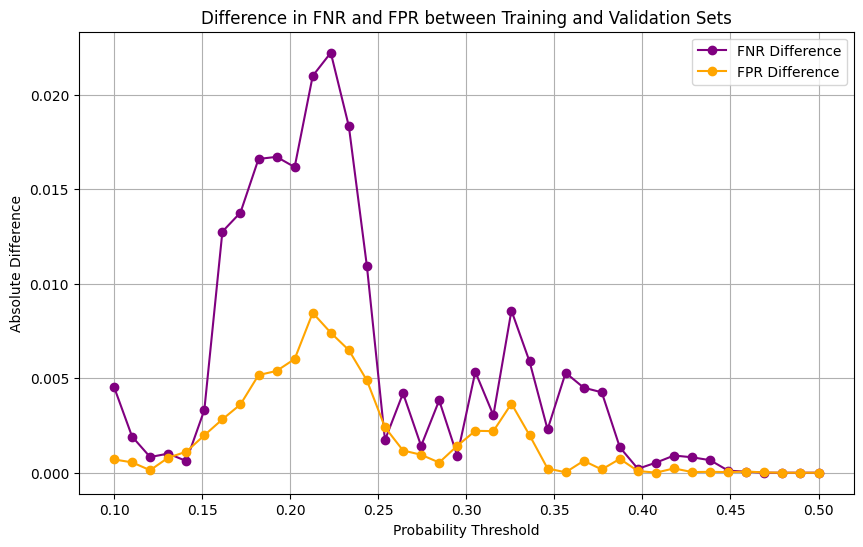

In [ ]:
# Calculate differences between training and validation FNR and FPR
fnr_diff = np.abs(np.array(train_fnrs) - np.array(valid_fnrs))
fpr_diff = np.abs(np.array(train_fnps) - np.array(valid_fnps))

# Plotting the differences
plt.figure(figsize=(10, 6))
plt.plot(thresholds, fnr_diff, label='FNR Difference', marker='o', color='purple')
plt.plot(thresholds, fpr_diff, label='FPR Difference', marker='o', color='orange')
plt.xlabel('Probability Threshold')
plt.ylabel('Absolute Difference')
plt.title('Difference in FNR and FPR between Training and Validation Sets')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
pca_test_data.drop(columns = 'is_bound', axis=1, inplace = True)

<ipython-input-55-e16682e4656d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pca_test_data.drop(columns = 'is_bound', axis=1, inplace = True)


In [ ]:
# Initializing logistic regression model
final_logistic_model = LogisticRegression(solver='liblinear', max_iter=1000,
                                           penalty='l1')

## Fitting model
final_logistic_model.fit(x_pca_train, y_pca_train)


# predicting probabilities on validation set
y_test_pred_prob = final_logistic_model.predict_proba(pca_test_data)[:, 1]
y_test_pred = (y_test_pred_prob >= optimal_threshold).astype(int)


list_predictions = y_test_pred.tolist()
rounded_list_predictions = [int(x) for x in list_predictions]
print(rounded_list_predictions)


[1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 

Modelling Two Approach B

I would like to determine if runnig the model without pca would be better

In [ ]:
# Splitting the train dataset to perform a CV logistic regression.
logit_x_train, x_valid, logit_y_train, y_valid = skm.train_test_split(x_train, y_train, test_size=0.2, random_state=42)

The threshold where validation FNR and FPR intersect is approximately: 0.23


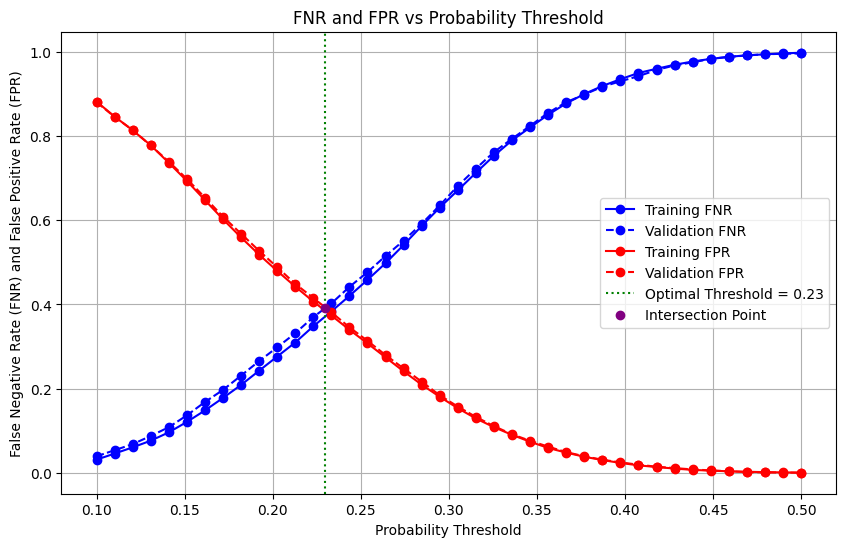

In [ ]:
# Initializing logistic regression model
model = LogisticRegressionCV(cv=kfold, scoring='roc_auc', penalty='l1',
                             max_iter=1000, solver='liblinear')
# Fitting model
model.fit(logit_x_train, logit_y_train)

# Creating thresholds and setting up variables to use in logistic regression
thresholds = np.linspace(0.1, 0.5, 40)
train_fnrs = []
train_fnps = []
valid_fnrs = []
valid_fnps = []


# Performing cross-validated logistic regression with PCA dataset
for threshold in thresholds:

    # Predicting probabilities on training set
    y_train_pred_prob = model.predict_proba(logit_x_train)[:, 1]
    y_train_pred = (y_train_pred_prob >= threshold).astype(int)

    # Calculating False Negative Rate and False Positive Rate for training set
    tn, fp, fn, tp = confusion_matrix(logit_y_train, y_train_pred).ravel()
    train_fnrs.append(fn / (fn + tp))
    train_fnps.append(fp / (fp + tn))

    # Predicting probabilities on validation set
    y_valid_pred_prob = model.predict_proba(x_valid)[:, 1]
    y_valid_pred = (y_valid_pred_prob >= threshold).astype(int)

    # Calculating False Negative Rate and False Positive Rate for validation set
    tn, fp, fn, tp = confusion_matrix(y_valid, y_valid_pred).ravel()
    valid_fnrs.append(fn / (fn + tp))
    valid_fnps.append(fp / (fp + tn))

# Interpolating FNR and FPR curves for the validation set
fnr_interp = interp1d(thresholds, valid_fnrs, kind='linear')
fpr_interp = interp1d(thresholds, valid_fnps, kind='linear')

# Generating a finer range of thresholds for finding intersections
fine_thresholds = np.linspace(thresholds.min(), thresholds.max(), 500)
fnr_fine = fnr_interp(fine_thresholds)
fpr_fine = fpr_interp(fine_thresholds)

# Finding the intersection point
diffs = np.abs(fnr_fine - fpr_fine)
min_index = np.argmin(diffs)
optimal_threshold = fine_thresholds[min_index]
intersection_fnr_fpr = fnr_fine[min_index]  # FNR and FPR at intersection

# Print the optimal threshold
print(f"The threshold where validation FNR and FPR intersect is approximately: {optimal_threshold:.2f}")

# Plotting the FNR and FPR for each threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, train_fnrs, label='Training FNR', marker='o', color='blue')
plt.plot(thresholds, valid_fnrs, label='Validation FNR', marker='o', color='blue', linestyle='--')
plt.plot(thresholds, train_fnps, label='Training FPR', marker='o', color='red')
plt.plot(thresholds, valid_fnps, label='Validation FPR', marker='o', color='red', linestyle='--')

# Mark the optimal threshold on the plot
plt.axvline(optimal_threshold, color='green', linestyle=':', label=f'Optimal Threshold = {optimal_threshold:.2f}')
plt.scatter(optimal_threshold, intersection_fnr_fpr, color='purple', label='Intersection Point', zorder=5)

# Labels and titles
plt.xlabel('Probability Threshold')
plt.ylabel('False Negative Rate (FNR) and False Positive Rate (FPR)')
plt.title('FNR and FPR vs Probability Threshold')
plt.legend()
plt.grid(True)
plt.show()

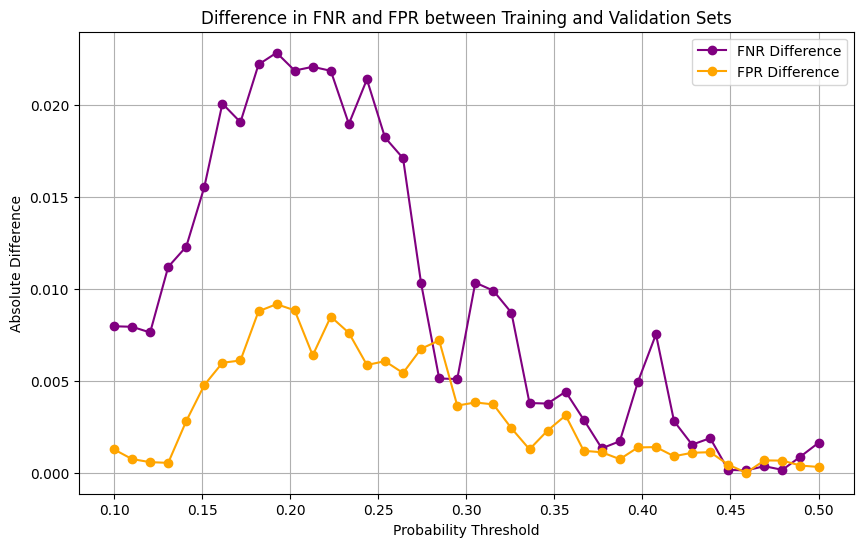

In [ ]:
# dropping is_bound column in test data
# test_data.drop(columns = 'is_bound', axis=1, inplace = True)

# Calculate differences between training and validation FNR and FPR
fnr_diff = np.abs(np.array(train_fnrs) - np.array(valid_fnrs))
fpr_diff = np.abs(np.array(train_fnps) - np.array(valid_fnps))

# Plotting the differences
plt.figure(figsize=(10, 6))
plt.plot(thresholds, fnr_diff, label='FNR Difference', marker='o', color='purple')
plt.plot(thresholds, fpr_diff, label='FPR Difference', marker='o', color='orange')
plt.xlabel('Probability Threshold')
plt.ylabel('Absolute Difference')
plt.title('Difference in FNR and FPR between Training and Validation Sets')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Initializing logistic regression model
final_logistic_model = LogisticRegression(solver='liblinear', max_iter=1000,
                                           penalty='l1')

## Fitting model
final_logistic_model.fit(x_train, y_train)


# predicting probabilities on validation set
y_test_pred_prob = final_logistic_model.predict_proba(test_data)[:, 1]
y_test_pred = (y_test_pred_prob >= optimal_threshold).astype(int)


list_predictions = y_test_pred.tolist()
rounded_list_predictions = [int(x) for x in list_predictions]
print(rounded_list_predictions)

[1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 